In [1]:
# The code was removed by Watson Studio for sharing.

# Predicting English Premier League Matches

By: Yi Xuan Sim

## Feature Creation

Loading the transformed dataset

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
df_data_1.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HST,AST,HTR,FT_encoded,HT_encoded
0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,2.0,6.0,D,1,1
1,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,5.0,5.0,A,0,0
2,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,7.0,4.0,D,1,1
3,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,8.0,3.0,D,1,1
4,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,2.0,7.0,D,1,1


## Determining Home Advantage
We first explore whether playing as the home team has advantages over playing as the away team.

We sum up the number of goals scored by home teams at full time divided by the number of matches to obtain the average score for home teams. We do the same for away teams, then compare the scores.

In [4]:
#total number of goals scored by the home teams 
n_g_home = df_data_1.FTHG.sum()*1.0
#total number of goals scored by the away teams
n_g_away = df_data_1.FTAG.sum()*1.0

#Total number of matches, equivalent to total number of rows of data
n_match = df_data_1.shape[0]

#average score for home teams
avg_home = n_g_home / n_match
#aveage score for away teams
avg_away = n_g_away / n_match

#the scores average is rounded up and printed out to give a clearer interpretation
avg_home_1 = str(round(avg_home,1))
avg_away_1 = str(round(avg_away,1))
Home_adv = (avg_home-avg_away)/avg_away*100
Home_adv = str(round(Home_adv,1))

print("Average number of goals at home",avg_home_1)
print("Average number of goals away", avg_away_1)
print("Home advantage", Home_adv, "%")

Average number of goals at home 1.5
Average number of goals away 1.1
Home advantage 35.8 %


From the results above, we can see that home teams generally perform better than away teams. This could be due to numerous factors, such as the fact that the away team has to travel a distance to reach the stadium, which contributes to fatigue.

## Strategy to Evaluate Team Performance
For future football matches, we will only be given the names of the home team and the away team. Thus, we need to develop a method of scoring the performance of the teams. 

We will score the team based on 4 aspects: the attacking score, the defending score, the attacking efficiency and the inverse defending efficiency. Due to the performance difference for home and away teams, we need a separate score for when the team is playing as the home team, and when the team is playing as the away team. 

We will now evaluate the performance of each team using 8 features:

1) Home Attacking Score = Number of goals scored by team when playing as home team / Number of matches playing as home team 

2) Away Attacking Score = Number of goals scored by team when playing as away team / Number of matches playing as away team

3) Home Defending Score = Number of goals conceded by team when playing as home team /Number of matches playing as home team

4) Away Defending Score = Number of goals conceded by team when playing as away team /Number of matches playing as away team

5) Home Attacking Efficiency = Number of goals scored when playing as home team / Number of shots on target playing as home team

6) Away Attacking Efficiency = Number of goals scored when playing as away team / Number of shots on target playing as away team

7) Home Inverse Defending Efficiency = Number of goals conceded when playing as home team / Number of shots on target by opposing team

8) Away Inverse Defending Efficiency = Number of goals conceded when playing as away team / Number of shots on target by opposing team

The number of goals conceded by team is equivalent to the number of goals scored by opposing team. For attacking scores, a higher value indicates better performance, while for defending scores, a lower value indicates better performance.


In [5]:
#Group teams according to home or away teams
homegroup = df_data_1.groupby('HomeTeam')
awaygroup = df_data_1.groupby('AwayTeam')

In [9]:
# Get team names
teamnames = homegroup.HomeTeam.all().values #copy the home team name 
data_2 = pd.DataFrame()
data_2['teamnames'] = teamnames
data_2.head()

,teamnames
0,Arsenal
1,Aston Villa
2,Birmingham
3,Blackburn
4,Bolton


In [10]:
# values needed to calculate the 8 features
data_2['n_homegoals'] = homegroup.FTHG.sum().values #copy the sum of home score for a specific home team
data_2['n_homeconcede'] = homegroup.FTAG.sum().values #copy the sum of away score for a specific home team
data_2['n_awaygoals'] = awaygroup.FTAG.sum().values #copy the sum of away score for a specific away team
data_2['n_awayconcede'] = awaygroup.FTHG.sum().values #copy the sum of home score for a specific away team
data_2['n_hst'] = homegroup.HST.sum().values #copy the sum of home shots on target for a specific home team
data_2['n_hsto'] = homegroup.AST.sum().values #copy the sum of shots on target by opposing team for a specific home team
data_2['n_ast'] = awaygroup.AST.sum().values #copy the sum of away shots on target for a specific away team
data_2['n_asto'] = awaygroup.HST.sum().values #copy the sum of shots on target by opposing team for a specific away team

# count the number of home and away matches for every team
data_2['n_homematch'] = homegroup.HomeTeam.count().values
data_2['n_awaymatch'] = awaygroup.AwayTeam.count().values

In [12]:
#Create the 8 features
data_2['home_attack_score'] = (data_2.n_homegoals / data_2.n_homematch)  
data_2['away_attack_score'] = (data_2.n_awaygoals / data_2.n_awaymatch)  
data_2['home_defense_score'] = (data_2.n_homeconcede / data_2.n_homematch)  
data_2['away_defense_score'] = (data_2.n_awayconcede / data_2.n_awaymatch)
data_2['home_attack_efficiency'] = (data_2.n_homegoals / data_2.n_hst) 
data_2['away_attack_efficiency'] = (data_2.n_awaygoals / data_2.n_ast) 
data_2['home_inv_defense_efficiency'] = (data_2.n_homeconcede / data_2.n_hsto) 
data_2['away_inv_defense_efficiency'] = (data_2.n_awayconcede / data_2.n_asto) 


### Normalizing features
Now, we normalize the new features that we just created for better performance

In [13]:
from sklearn.preprocessing import scale
cols = [['home_attack_score','away_attack_score','home_defense_score','away_defense_score','home_attack_efficiency','away_attack_efficiency','home_inv_defense_efficiency','away_inv_defense_efficiency']] 
for col in cols:
    data_2[col] = scale(data_2[col]) 
    
data_2.head()

,teamnames,n_homegoals,n_homeconcede,n_awaygoals,n_awayconcede,n_hst,n_hsto,n_ast,n_asto,n_homematch,n_awaymatch,home_attack_score,away_attack_score,home_defense_score,away_defense_score,home_attack_efficiency,away_attack_efficiency,home_inv_defense_efficiency,away_inv_defense_efficiency
0,Arsenal,566.0,208.0,420.0,333.0,2090.0,994.0,1585.0,1289.0,258,257,2.117749,2.010511,-1.481912,-1.247002,0.548548,0.874321,-0.696817,-0.004143
1,Aston Villa,256.0,251.0,239.0,338.0,1126.0,1207.0,1006.0,1472.0,209,209,-0.367044,0.453356,-0.143126,-0.189184,-0.241390,0.318137,-0.722440,-0.633718
2,Birmingham,87.0,69.0,63.0,137.0,425.0,448.0,372.0,646.0,76,76,-0.572572,-0.544953,-1.137026,0.420843,-0.653038,-1.066144,-1.783932,-1.018328
3,Blackburn,192.0,153.0,131.0,239.0,871.0,756.0,690.0,995.0,133,133,0.193886,-0.049866,-0.314668,0.402289,-0.367118,-0.650164,-0.832113,-0.401763
4,Bolton,174.0,173.0,129.0,238.0,964.0,898.0,648.0,1034.0,133,133,-0.153189,-0.097585,0.195321,0.377551,-1.093047,-0.463096,-1.023619,-0.621563


### Visualizing features
Now we visualize the data by plotting it

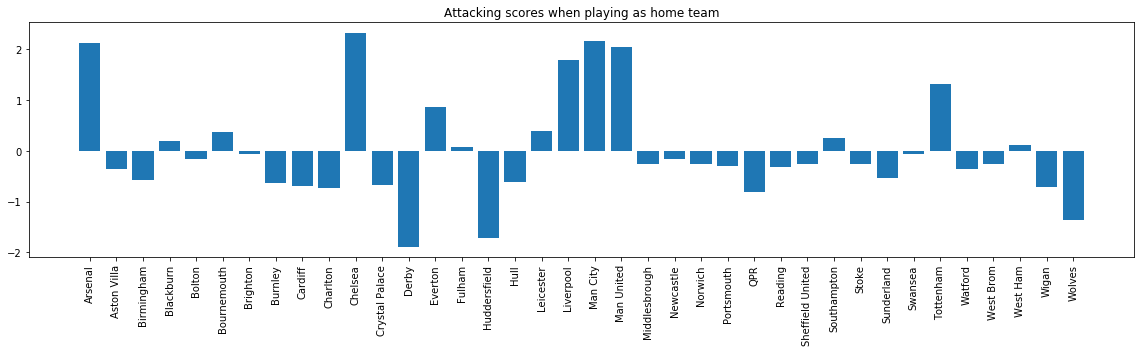

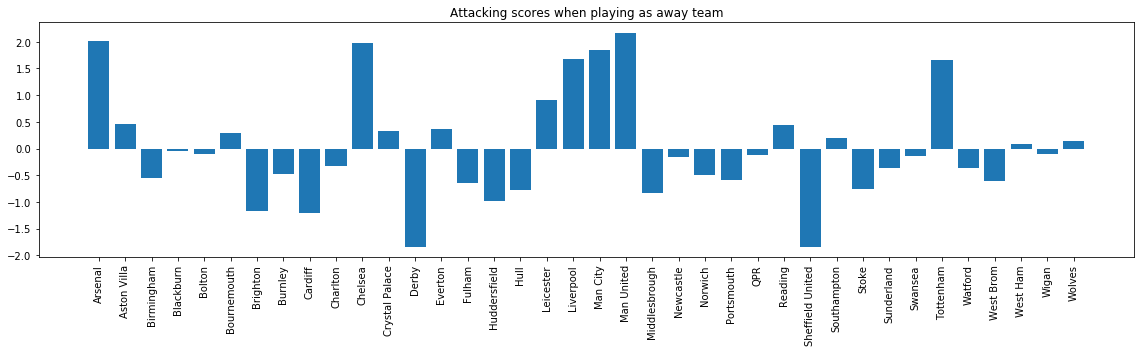

In [14]:
#Need this to display the plots
%matplotlib inline

import matplotlib.pyplot as plt 

#plotting bar chart of Team against HAS
x=data_2['teamnames']
y=data_2['home_attack_score']
plt.figure(figsize=(16,5))
plt.bar(x,y)
plt.title('Attacking scores when playing as home team')
plt.xticks(rotation=90)
plt.tight_layout()

#plotting bar chart of Team against AAS
x=data_2['teamnames']
y=data_2['away_attack_score']
plt.figure(figsize=(16,5))
plt.bar(x,y)
plt.title('Attacking scores when playing as away team')
plt.xticks(rotation=90)
plt.tight_layout()

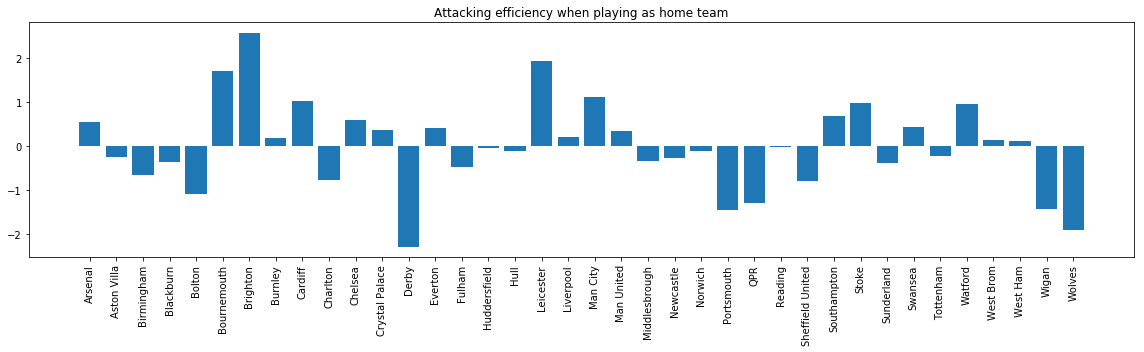

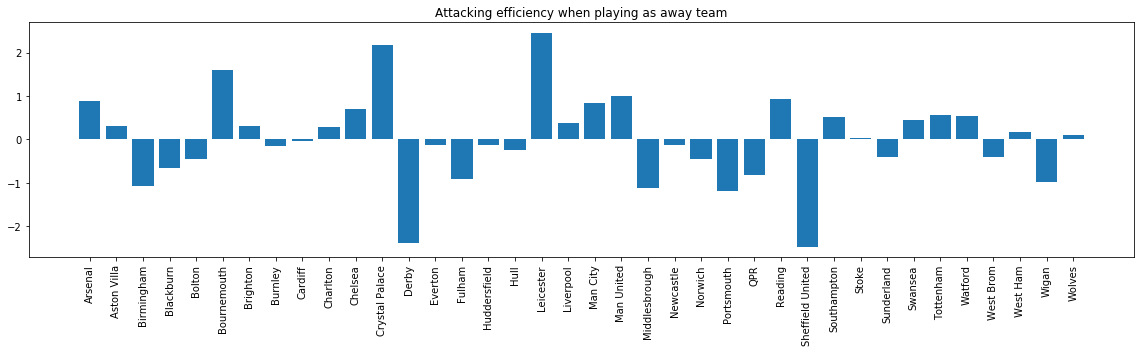

In [15]:
#plotting bar chart of Team against HAE
x=data_2['teamnames']
y=data_2['home_attack_efficiency']
plt.figure(figsize=(16,5))
plt.bar(x,y)
plt.title('Attacking efficiency when playing as home team')
plt.xticks(rotation=90)
plt.tight_layout()

#plotting bar chart of Team against AAE
x=data_2['teamnames']
y=data_2['away_attack_efficiency']
plt.figure(figsize=(16,5))
plt.bar(x,y)
plt.title('Attacking efficiency when playing as away team')
plt.xticks(rotation=90)
plt.tight_layout()

### Making Sense of our data
From the plots above, we can see that strong teams, such as Arsenal, Chelsea, Liverpool, Manchester City and Manchester United have very high attacking scores. Thus, this confirms that our method of scoring the team's performance is reliable. We will now store these scores in a csv file, which we will then use for model training. 

In [16]:
# Save dataframe as csv file to storage
project.save_data(data=data_2.to_csv(index=False),file_name='team_scores2.csv',overwrite=True)

{'asset_id': '9885bc27-6909-4494-b186-3d43e09bfca0',
 'bucket_name': 'courseracapstone-donotdelete-pr-otnumxi5bu7tbr',
 'file_name': 'team_scores2.csv',
 'message': 'File team_scores2.csv has been written successfully to the associated OS'}

### Appending team performance scores to training data

Now we will append the calculated team performance scores to the training data. 

In [17]:
analysis_frame = df_data_1[['HomeTeam','AwayTeam','FTR']]
analysis_frame.head()

,HomeTeam,AwayTeam,FTR
0,Aston Villa,Bolton,D
1,Everton,Man United,A
2,Fulham,Birmingham,D
3,Man City,West Brom,D
4,Middlesbrough,Liverpool,D


In [19]:
#We apply the attacking and defending scores calculated for each team for every match

home_attack_score_analysis = []  
away_attack_score_analysis =[]
home_defense_score_analysis = []
away_defense_score_analysis = []
home_attack_efficiency_analysis = []  
away_attack_efficiency_analysis =[]
home_inv_defense_efficiency_analysis = []
away_inv_defense_efficiency_analysis = []


#this is to apply the attacking and defensive score of each team from Table_1 into each match in Table_2.
for index,row in analysis_frame.iterrows():
    home_attack_score_analysis.append(data_2[data_2['teamnames'] == row['HomeTeam']]['home_attack_score'].values[0])
    away_attack_score_analysis.append(data_2[data_2['teamnames'] == row['AwayTeam']]['away_attack_score'].values[0])
    home_defense_score_analysis.append(data_2[data_2['teamnames'] == row['HomeTeam']]['home_defense_score'].values[0])
    away_defense_score_analysis.append(data_2[data_2['teamnames'] == row['AwayTeam']]['away_defense_score'].values[0])
    home_attack_efficiency_analysis.append(data_2[data_2['teamnames'] == row['HomeTeam']]['home_attack_efficiency'].values[0])
    away_attack_efficiency_analysis.append(data_2[data_2['teamnames'] == row['AwayTeam']]['away_attack_efficiency'].values[0])
    home_inv_defense_efficiency_analysis.append(data_2[data_2['teamnames'] == row['HomeTeam']]['home_inv_defense_efficiency'].values[0])
    away_inv_defense_efficiency_analysis.append(data_2[data_2['teamnames'] == row['AwayTeam']]['away_inv_defense_efficiency'].values[0])
    

#creating new columns for the scores.
analysis_frame['home_attack_score_analysis'] = home_attack_score_analysis
analysis_frame['away_attack_score_analysis'] = away_attack_score_analysis
analysis_frame['home_defense_score_analysis'] = home_defense_score_analysis
analysis_frame['away_defense_score_analysis'] = away_defense_score_analysis
analysis_frame['home_attack_efficiency_analysis'] = home_attack_efficiency_analysis
analysis_frame['away_attack_efficiency_analysis'] = away_attack_efficiency_analysis
analysis_frame['home_inv_defense_efficiency_analysis'] = home_inv_defense_efficiency_analysis
analysis_frame['away_inv_defense_efficiency_analysis'] = away_inv_defense_efficiency_analysis

analysis_frame.head()

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,HomeTeam,AwayTeam,FTR,home_attack_score_analysis,away_attack_score_analysis,home_defense_score_analysis,away_defense_score_analysis,home_attack_efficiency_analysis,away_attack_efficiency_analysis,home_inv_defense_efficiency_analysis,away_inv_defense_efficiency_analysis
0,Aston Villa,Bolton,D,-0.367044,-0.097585,-0.143126,0.377551,-0.241390,-0.463096,-0.722440,-0.621563
1,Everton,Man United,A,0.855378,2.162607,-0.614336,-2.168971,0.418593,0.998026,-0.438074,-1.517423
2,Fulham,Birmingham,D,0.076383,-0.544953,0.074727,0.420843,-0.483306,-1.066144,-0.439501,-1.018328
3,Man City,West Brom,D,2.167449,-0.614544,-1.192720,-0.411329,1.120426,-0.396703,-0.398956,-0.544577
4,Middlesbrough,Liverpool,D,-0.268881,1.670617,0.067824,-1.633356,-0.334656,0.369332,-0.166129,-0.043594


Based on the team scores, we can now calculate the overall score of the match. a positive overall score favours the home team, while a negative overall score favours the away team.

In [20]:
#Difference in attacking score
x = analysis_frame['home_attack_score_analysis']
y = analysis_frame['away_attack_score_analysis'] 
analysis_frame["diff_attack"] = x-y 

#Difference in defending score
x = analysis_frame['away_defense_score_analysis']
y = analysis_frame['home_defense_score_analysis'] 
analysis_frame["diff_defense"] = x-y

#Overall Score
analysis_frame["overall_score"] = analysis_frame['diff_attack'] + analysis_frame['diff_defense']
analysis_frame.head()

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,HomeTeam,AwayTeam,FTR,home_attack_score_analysis,away_attack_score_analysis,home_defense_score_analysis,away_defense_score_analysis,home_attack_efficiency_analysis,away_attack_efficiency_analysis,home_inv_defense_efficiency_analysis,away_inv_defense_efficiency_analysis,diff_attack,diff_defense,overall_score
0,Aston Villa,Bolton,D,-0.367044,-0.097585,-0.143126,0.377551,-0.241390,-0.463096,-0.722440,-0.621563,-0.269459,0.520677,0.251218
1,Everton,Man United,A,0.855378,2.162607,-0.614336,-2.168971,0.418593,0.998026,-0.438074,-1.517423,-1.307229,-1.554635,-2.861864
2,Fulham,Birmingham,D,0.076383,-0.544953,0.074727,0.420843,-0.483306,-1.066144,-0.439501,-1.018328,0.621337,0.346116,0.967453
3,Man City,West Brom,D,2.167449,-0.614544,-1.192720,-0.411329,1.120426,-0.396703,-0.398956,-0.544577,2.781993,0.781391,3.563383
4,Middlesbrough,Liverpool,D,-0.268881,1.670617,0.067824,-1.633356,-0.334656,0.369332,-0.166129,-0.043594,-1.939499,-1.701180,-3.640678


Now we save the training data with scores into a csv file. We will use this data for model training. 

In [21]:
# Save dataframe as csv file to storage
project.save_data(data=analysis_frame.to_csv(index=False),file_name='training_scores2.csv',overwrite=True)

{'asset_id': '095877cf-df21-4072-a2e0-57a9dc2f7066',
 'bucket_name': 'courseracapstone-donotdelete-pr-otnumxi5bu7tbr',
 'file_name': 'training_scores2.csv',
 'message': 'File training_scores2.csv has been written successfully to the associated OS'}